# Загрузка библиотек

In [1]:
import re
import optuna

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from tqdm.notebook import tqdm
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import  roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold, StratifiedKFold

from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings("ignore")

# EDA

In [2]:
data = pd.read_csv("/kaggle/input/vk-data-spam/train_spam.csv")
data

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
...,...,...
16273,spam,if you are interested in binary options tradin...
16274,spam,dirty pictureblyk on aircel thanks you for bei...
16275,ham,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...


In [3]:
data.describe()

,text_type,text
count,16278,16278
unique,2,16267
top,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
freq,11469,7


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


In [5]:
data.isna().sum()

text_type    0
text         0
dtype: int64

In [6]:
data

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
...,...,...
16273,spam,if you are interested in binary options tradin...
16274,spam,dirty pictureblyk on aircel thanks you for bei...
16275,ham,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...


In [7]:
data['Length'] = data['text'].str.len()
data.head()

,text_type,text,Length
0,ham,make sure alex knows his birthday is over in f...,86
1,ham,a resume for john lavorato thanks vince i will...,520
2,spam,plzz visit my website moviesgodml to get all m...,126
3,spam,urgent your mobile number has been awarded wit...,139
4,ham,overview of hr associates analyst project per ...,733


In [8]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

data['Word_count'] = data['text'].apply(word_count)
data.head()

,text_type,text,Length,Word_count
0,ham,make sure alex knows his birthday is over in f...,86,16
1,ham,a resume for john lavorato thanks vince i will...,520,97
2,spam,plzz visit my website moviesgodml to get all m...,126,22
3,spam,urgent your mobile number has been awarded wit...,139,23
4,ham,overview of hr associates analyst project per ...,733,127


In [9]:
def visualize(col):
    plt.figure(figsize=(12, 6))
    print()
    plt.subplot(1, 2, 1)
    sns.boxplot(y=col, x='text_type', data=data)  
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1, 2, 2)
    sns.kdeplot(data=data, x=col, hue='text_type') 
    plt.xlabel('')
    plt.ylabel('')
    
    plt.show()

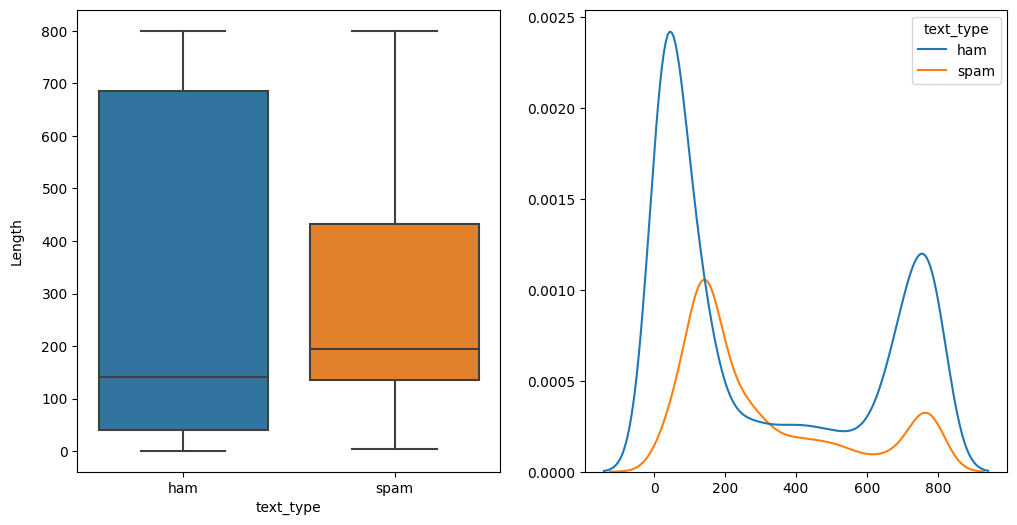

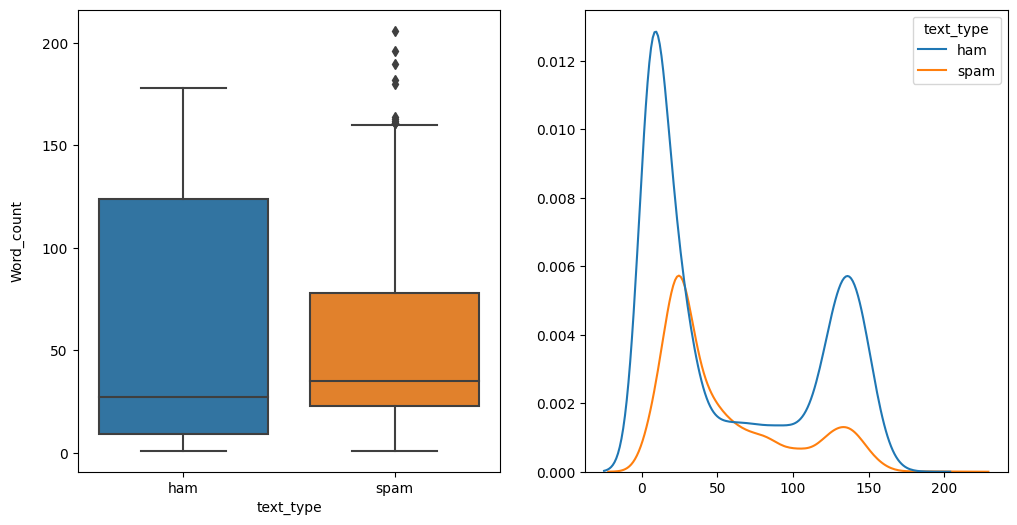

In [10]:
features = data.columns.tolist()[2:]
for feature in features:
    visualize(feature)

In [11]:
data["text_type"] = data["text_type"].replace("spam", 0)
data["text_type"] = data["text_type"].replace("ham", 1)

<Axes: ylabel='Frequency'>

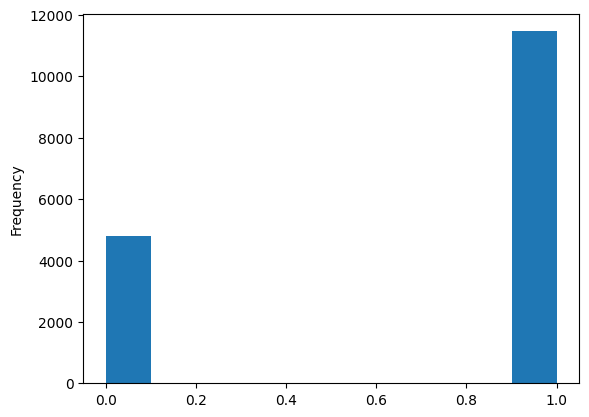

In [12]:
data["text_type"].plot(kind = 'hist')

Виден дизбаланс классов, поэтому будет использовать StratifiedKFold

# Очистка данных от смайликов и ненужных знаков

In [13]:
def clean_text(txt):
    word_clean = re.compile(r'[A-Za-z0-9]+')
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF" 
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF" 
                           "]+", flags = re.UNICODE)
    
    regrex_pattern.sub(r'',txt)
    
    words = ''
    txt = txt.lower()
#     txt = re.sub(r'\d+ of \d+', '', txt)  
    for word in re.findall(word_clean, txt):
        words = words + ' ' + word
    words = words.strip()
    return words.replace('\n', '')

In [14]:
corpus = []
def preprocess_text(text):
    text = re.sub(r'[\[\]~|]', '', text)
    return clean_text(text)
corpus = [preprocess_text(txt) for txt in data.text if txt is not None]

In [15]:
data["text"][7656]

'in the last 1 week i have made over 19 000 just with 8 000 investment its actually my first online trade investment and glad all thanks to btc and team 👇👇👇👇👇👇👇'

In [16]:
corpus[7656]

'in the last 1 week i have made over 19 000 just with 8 000 investment its actually my first online trade investment and glad all thanks to btc and team'

In [17]:
data["text"] = corpus

In [18]:
data["text"][7656]

'in the last 1 week i have made over 19 000 just with 8 000 investment its actually my first online trade investment and glad all thanks to btc and team'

In [19]:
y = data["text_type"]
X = data.drop(columns = ["text_type"])
# X = 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)

In [20]:
tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(X_train['text'])
X_test_tfidf = tfidf_vect.transform(X_test['text'])

train_pool = Pool(data=X_train_tfidf, label=y_train)
test_pool = Pool(data=X_test_tfidf, label=y_test)

# Обучение моделий

In [21]:
models_scores = {}

In [22]:
model = RandomForestClassifier()

model.fit(X_train_tfidf, y_train)
predict = model.predict_proba(X_test_tfidf)[:, 1]
print(roc_auc_score(y_test, predict))
models_scores['RandomForestClassifier'] = round(roc_auc_score(y_test, predict), 3)

0.9644333247699285


In [23]:
model = LogisticRegression()

model.fit(X_train_tfidf, y_train)
predict = model.predict_proba(X_test_tfidf)[:, 1]
print(roc_auc_score(y_test, predict))
models_scores['LogisticRegression'] = round(roc_auc_score(y_test, predict), 3)

0.9730739769305992


In [24]:
model = KNeighborsClassifier()

model.fit(X_train_tfidf, y_train)
predict = model.predict_proba(X_test_tfidf)[:, 1]
print(roc_auc_score(y_test, predict))
models_scores['KNeighborsClassifier'] = round(roc_auc_score(y_test, predict), 3)

0.716478315899006


In [25]:
model = CatBoostClassifier(verbose = 0, iterations=1000, depth=5, random_seed=2314)

model.fit(train_pool)
predict = model.predict_proba(test_pool)[:, 1]
print(roc_auc_score(y_test, predict))
models_scores['CatBoostClassifier'] = round(roc_auc_score(y_test, predict), 3)

0.9725869516662001


In [26]:
models_benchmark = pd.DataFrame(data=models_scores.items(), columns=['Model', 'ROC_AUC'])
models_benchmark

,Model,ROC_AUC
0,RandomForestClassifier,0.964
1,LogisticRegression,0.973
2,KNeighborsClassifier,0.716
3,CatBoostClassifier,0.973


In [27]:
print("Best model:")
sorted(models_scores.items(), key=lambda x:x[1])[-1]

Best model:


('CatBoostClassifier', 0.973)

In [28]:
n_splits = 5
clfs = []
scores = []
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7575)
fold_number = 0
for train_index, test_index in kf.split(X=X, y=y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     tfidf_vect = TfidfVectorizer()
    X_train_tfidf = tfidf_vect.transform(X_train['text'])
    X_test_tfidf = tfidf_vect.transform(X_test['text'])

    train_pool = Pool(data=X_train_tfidf, label=y_train)
    test_pool = Pool(data=X_test_tfidf, label=y_test)
    
    clf = CatBoostClassifier(iterations=1000, depth=5, verbose = 0, loss_function = "Logloss")
    clfs.append(clf)

    clf.fit(train_pool)

    y_pred = clf.predict_proba(test_pool)[:, 1]
    score = roc_auc_score(y_test, y_pred)
#     score = np.mean(np.array(y_pred == y_test))
    scores.append(score)
    print(f"fold {fold_number}: roc_auc: {score}")
    fold_number += 1

assert len(clfs) == n_splits
print(
    "mean roc_auc score --", np.mean(scores, dtype="float16"), np.std(scores).round(4)
)
models_scores['CatBoostClassifier_CV'] = round(np.mean(scores, dtype="float16"), 3)

fold 0: roc_auc: 0.9727948893162494
fold 1: roc_auc: 0.972046983271918
fold 2: roc_auc: 0.9644285825628458
fold 3: roc_auc: 0.9712764693127891
fold 4: roc_auc: 0.9752605099312469
mean roc_auc score -- 0.971 0.0036


In [29]:
models_benchmark = pd.DataFrame(data=models_scores.items(), columns=['Model', 'ROC_AUC'])
models_benchmark

,Model,ROC_AUC
0,RandomForestClassifier,0.964000
1,LogisticRegression,0.973000
2,KNeighborsClassifier,0.716000
3,CatBoostClassifier,0.973000
4,CatBoostClassifier_CV,0.971191


In [30]:
test = pd.read_csv("/kaggle/input/vk-data-spam/test_spam.csv")
test

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...
...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...
4066,baylor enron case study cindy yes i shall co a...
4067,boring as compared to tp
4068,hellogorgeous hows u my fone was on charge lst...


In [31]:
test_text = [] 
def preprocess_text(text):
    text = re.sub(r'[\[\]~|]', '', text)
    return clean_text(text)
test_text = [preprocess_text(txt) for txt in test.text if txt is not None]

In [32]:
test_text[0]

'j jim whitehead ejw cse ucsc edu writes j you open sourced the new components you developed for this j project so the next person who comes along won t have to j reimplement them right no need all those components already exist either in the java class libraries or from the various java jar collections most of the classes i used came from the jakarta project and apachexml but if it s any consolation my threading of them all together into a newswire server is gpl and available on sourceforge gary lawrence murphy garym teledyn com teledynamics communications inc business advantage through community software url computers are useless they can only give you answers pablo picasso'

In [33]:
test_txt = tfidf_vect.transform(test_text)

In [34]:
test_pool = Pool(data=test_txt)

In [35]:
y_pred = np.zeros((test.shape[0], data[['text_type']].nunique()[0]))

for clf in clfs:
    y_pred += clf.predict_proba(test_pool)

f = lambda x: clf.classes_[x]
test["text_type"] = list(map(f, y_pred.argmax(axis=1)))

In [36]:
test

,text,text_type
0,j jim whitehead ejw cse ucsc edu writes j you ...,1
1,original message from bitbitch magnesium net p...,1
2,java for managers vince durasoft who just taug...,1
3,there is a youtuber name saiman says,1
4,underpriced issue with high return on equity t...,1
...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,1
4066,baylor enron case study cindy yes i shall co a...,1
4067,boring as compared to tp,1
4068,hellogorgeous hows u my fone was on charge lst...,1


In [37]:
test['text_type'].to_list().count(0)

971

In [38]:
test.to_csv("resualt.csv",index=False)